<a href="https://colab.research.google.com/github/abdullahsayyad/Satellite-Imagery-Segmentation-U-Net/blob/main/Satellite_Imagery_Segmentation_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing dependencies

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import kagglehub
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import glob

##Setting up device agnostic

In [2]:
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

#Downloading satellite image dataset

In [3]:
source_path = kagglehub.dataset_download("humansintheloop/semantic-segmentation-of-aerial-imagery")
target_path = "./"

shutil.copytree(source_path, target_path, dirs_exist_ok=True)

print("Dataset moved to:", target_path)

Dataset moved to: ./


##Data exploration and Analysis

In [4]:
import os
from pathlib import Path

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
      print(f"There are {len(dirnames)} directories and {len(filenames)} and images in {dirpath}")


image_path_list = []
mask_path_list = []


for i in range(1,10):
    data_path = Path(f"./Semantic segmentation dataset/Tile {i}")

    path_to_image = list(data_path.glob("images/*.jpg"))
    path_to_mask = list(data_path.glob("masks/*.png"))
    image_path_list.extend(path_to_image)
    mask_path_list.extend(path_to_mask)

    # walk_through_dir(data_path)

image_path_list = sorted(image_path_list, key=lambda x: x.name)
mask_path_list = sorted(mask_path_list, key=lambda x: x.name)


print(image_path_list)
print(mask_path_list)


[PosixPath('Semantic segmentation dataset/Tile 1/images/image_part_001.jpg'), PosixPath('Semantic segmentation dataset/Tile 2/images/image_part_001.jpg'), PosixPath('Semantic segmentation dataset/Tile 3/images/image_part_001.jpg'), PosixPath('Semantic segmentation dataset/Tile 4/images/image_part_001.jpg'), PosixPath('Semantic segmentation dataset/Tile 5/images/image_part_001.jpg'), PosixPath('Semantic segmentation dataset/Tile 6/images/image_part_001.jpg'), PosixPath('Semantic segmentation dataset/Tile 7/images/image_part_001.jpg'), PosixPath('Semantic segmentation dataset/Tile 8/images/image_part_001.jpg'), PosixPath('Semantic segmentation dataset/Tile 1/images/image_part_002.jpg'), PosixPath('Semantic segmentation dataset/Tile 2/images/image_part_002.jpg'), PosixPath('Semantic segmentation dataset/Tile 3/images/image_part_002.jpg'), PosixPath('Semantic segmentation dataset/Tile 4/images/image_part_002.jpg'), PosixPath('Semantic segmentation dataset/Tile 5/images/image_part_002.jpg')

##Creating train and test splits
* Using train_test_split() from Scikit-Learn







In [5]:
image_train, image_test, mask_train, mask_test = train_test_split(image_path_list, mask_path_list, test_size=0.2, random_state=42)
len(image_train), len(mask_train), len(image_test), len(mask_test)

(57, 57, 15, 15)

##Visualizing train and test split in image form

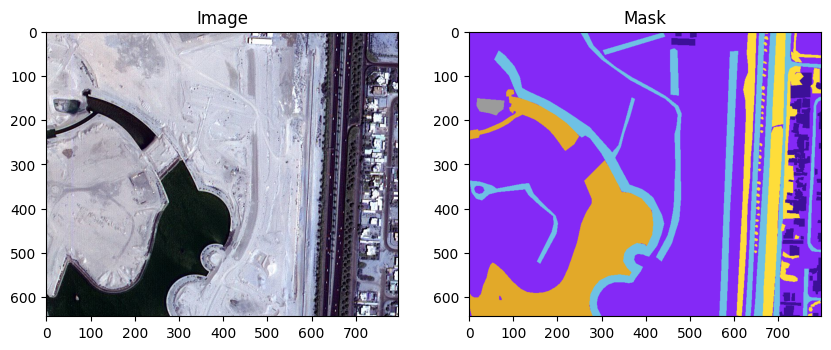

In [6]:
img = Image.open(image_path_list[16])
mask = Image.open(mask_path_list[16])

plt.figure(figsize=(10,5))


plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Image")
plt.axis('on')


plt.subplot(1,2,2)
plt.imshow(mask)
plt.title("Mask")
plt.axis('on')

plt.show()

##Creating transform

In [7]:
image_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

##Creating custom dataset for Satellite image for preprocessing the images
* Resizing images to 256x256 size
* Creating a color map for the mask images
* Returning image and mask as tensors


In [8]:
class SatelliteImagery(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

        self.color_map = {
            (60, 16, 152): 0,
            (132, 41, 246): 1,
            (110, 193, 228): 2,
            (254, 221, 58): 3,
            (226, 169, 41): 4,
            (155, 155, 155): 5,
        }

    def rgb_to_class(self, mask):
        mask_np = np.array(mask)
        label_mask = np.zeros((mask_np.shape[0], mask_np.shape[1]), dtype=np.int64)

        for rgb, idx in self.color_map.items():
            matches = np.all(mask_np == rgb, axis=-1)
            label_mask[matches] = idx

        return torch.tensor(label_mask, dtype=torch.long)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("RGB")

        img = img.resize((256, 256))
        mask = mask.resize((256, 256), resample=Image.NEAREST)

        if self.transform:
            img = self.transform(img)

        mask = self.rgb_to_class(mask)

        return img, mask



##Visualizing train and test dataset after preprocessing

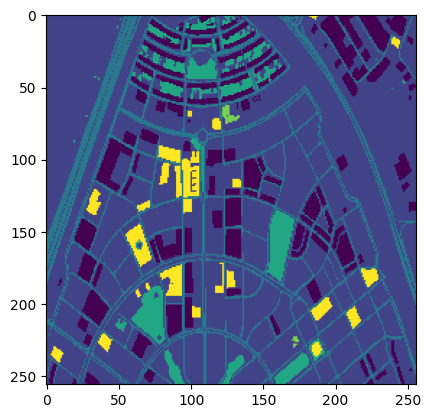

15

In [9]:
train_dataset = SatelliteImagery(image_train, mask_train, image_transform)
test_dataset = SatelliteImagery(image_test, mask_test, image_transform)


mask_img = test_dataset[10][1]
mask_img = mask_img.to(torch.uint8)
# mask_img = mask_img.permute(1,2,0)

plt.imshow(mask_img.numpy())
plt.show(), test_dataset[10][1]

len(test_dataset)

##Creating Dataloaders

In [10]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 8


train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)


test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=len(test_dataset),
                              num_workers=NUM_WORKERS,
                              shuffle=False)

In [11]:
len(train_dataloader), len(test_dataloader)

(8, 1)

##Building Double convolutional layer class

In [12]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias = False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias = False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

  def forward(self, x):
    return self.conv(x)

##Building the U-NET architecture

In [13]:
class UNET(nn.Module):
  def __init__(self, in_channels = 3, out_channels=6, features=[64, 128, 256, 512]):
    super(UNET, self).__init__()
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature

    for feature in reversed(features):
      self.ups.append(
          nn.ConvTranspose2d(
              feature*2, feature, kernel_size=2, stride=2
          )
      )

      self.ups.append(DoubleConv(feature*2, feature))

    self.bottleneck = DoubleConv(features[-1], features[-1]*2)
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

  def forward(self, x):
    skip_connections = []

    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1]

    for idx in range(0, len(self.ups), 2):
      x = self.ups[idx](x)
      skip_connection = skip_connections[idx//2]


      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connection.shape[2:])


      concat_skip = torch.cat((skip_connection, x), dim=1)
      x = self.ups[idx+1](concat_skip)

    return self.final_conv(x)


##Creating training and testing steps

In [14]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):

    model.train()
    train_loss = 0
    correct_pixels = 0
    total_pixels = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(y_pred, dim=1)

        correct_pixels += (y_pred_class == y).sum().item()
        total_pixels += torch.numel(y)

    train_loss = train_loss / len(dataloader)
    train_acc = correct_pixels / total_pixels

    return train_loss, train_acc


In [15]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):

    model.eval()

    test_loss, correct_pixels, total_pixels = 0, 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)

            correct_pixels += (test_pred_labels == y).sum().item()
            total_pixels += torch.numel(y)

    test_loss /= len(dataloader)
    test_acc = correct_pixels / total_pixels

    return test_loss, test_acc


##Building the training loop

In [16]:
from tqdm.auto import tqdm
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int = 5,
          device = device):

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)

    test_loss , test_acc = test_step(model=model,
                                     dataloader=test_dataloader,
                                     loss_fn=loss_fn,
                                     device=device)

    torch.cuda.empty_cache()

    print(f"Epoch: {epoch} | Train Loss: {train_loss} | Train acc: {train_acc} | Test Loss: {test_loss} | Test acc: {test_acc}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

##Defining our model

In [17]:
model = UNET(in_channels=3,
             out_channels=6).to(device)

model

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

##Training of model begins

In [18]:
torch.manual_seed(42)
NUM_EPOCHS = 50

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.0001)


model_0_results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.642108604311943 | Train acc: 0.37978965357730265 | Test Loss: 1.7768384218215942 | Test acc: 0.0585906982421875
Epoch: 1 | Train Loss: 1.308929681777954 | Train acc: 0.6047788921155428 | Test Loss: 1.4883606433868408 | Test acc: 0.7487691243489584
Epoch: 2 | Train Loss: 1.2394125759601593 | Train acc: 0.6398205673485472 | Test Loss: 1.1718744039535522 | Test acc: 0.764093017578125
Epoch: 3 | Train Loss: 1.177358701825142 | Train acc: 0.6738018905907347 | Test Loss: 0.9405034184455872 | Test acc: 0.7805135091145833
Epoch: 4 | Train Loss: 1.0766057968139648 | Train acc: 0.6829228986773574 | Test Loss: 0.8232154846191406 | Test acc: 0.7977630615234375
Epoch: 5 | Train Loss: 1.0440940484404564 | Train acc: 0.6999075370922423 | Test Loss: 0.792514443397522 | Test acc: 0.7999755859375
Epoch: 6 | Train Loss: 1.0521634370088577 | Train acc: 0.7027100680167215 | Test Loss: 0.8032810091972351 | Test acc: 0.7620595296223959
Epoch: 7 | Train Loss: 0.9814170300960541 | Trai

##Saving model

In [19]:
torch.save(model.state_dict(), 'model_final.pth')

##Predicting on a new Image

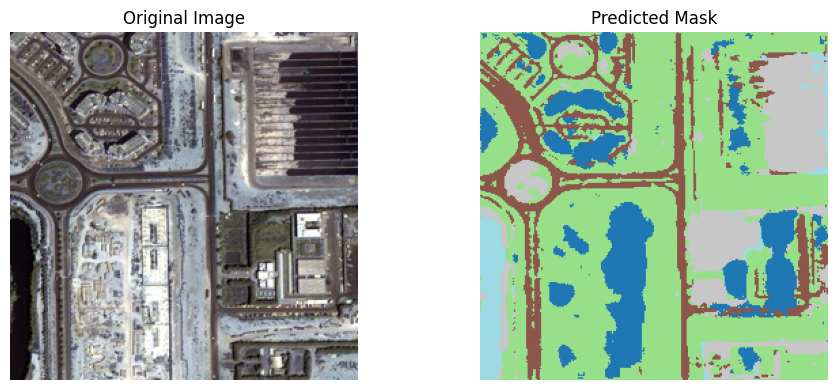

In [22]:

model_test = UNET(in_channels=3, out_channels=6)
state_dict = torch.load('model_final.pth', weights_only=False)
model_test.load_state_dict(state_dict)
model_test.to(device)
model_test.eval()


def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img = img.resize((256, 256))

    img_tensor = TF.to_tensor(img)
    img_tensor = TF.normalize(img_tensor, mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
    img_tensor = img_tensor.unsqueeze(0).to(device)
    return img_tensor, img


@torch.no_grad()
def predict(img_path):
    img_tensor, orig_img = preprocess_image(img_path)
    output = model(img_tensor)
    pred_mask = output.argmax(1).squeeze(0).cpu().numpy()

    return orig_img, pred_mask


def displayPrediction(img_path):
    orig_img, pred_mask = predict(img_path)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(orig_img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask, cmap='tab20')
    plt.title("Predicted Mask")
    plt.axis("off")
    plt.tight_layout()
    plt.show()




displayPrediction("Semantic segmentation dataset/Tile 2/images/image_part_006.jpg")
